In [1]:
# Import python directory
import sys
sys.path.append('..')

import torch
from PIL import Image
import matplotlib.pyplot as plt
from src.domain import Domain
from src.interpolation import SplineInter
from src.transformations import Affine2d
from src.plotting import view_image_2d, plot_grid_2d
from src.super_resolution_tools import *
from src.transformations import Affine2d
from src.LinearOperator import LinearOperator
from src.lanczos import lanczos_tridiag
# from src.conjugate_gradient import conjugate_gradient
from src.utils import * 
from src.optimization import *
import torch.func as func
from src.distance import SSDDistance
import time

torch.set_default_dtype(torch.float64)

In [2]:
def show_reference_and_templates(R, T):

    # Determine the layout for the subplots
    num_images = 1 + T.shape[0]  # Total number of images (reference + targets)
    cols = int(torch.ceil(torch.sqrt(torch.tensor(num_images).float())))  # Number of columns (and rows in a square layout)
    rows = int(torch.ceil(torch.tensor(num_images).float() / cols))  # Number of rows needed to accommodate all images

    # Create the figure with subplots
    _, ax = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

    # Flatten the ax array for easier indexing
    ax = ax.flatten()

    # Display the reference image
    ax[0].imshow(R.detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
    ax[0].set_title('Reference')
    ax[0].axis('off')  # Optional: hide axes for cleaner visualization

    # Display the target images
    for k in range(T.shape[0]):
        ax[k + 1].imshow(T[k].detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
        ax[k + 1].set_title(f'T_{k}')
        ax[k + 1].axis('off')  # Optional: hide axes for cleaner visualization

    # Turn off any unused subplots
    for i in range(1 + T.shape[0], len(ax)):
        ax[i].axis('off')

    plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
    plt.show()

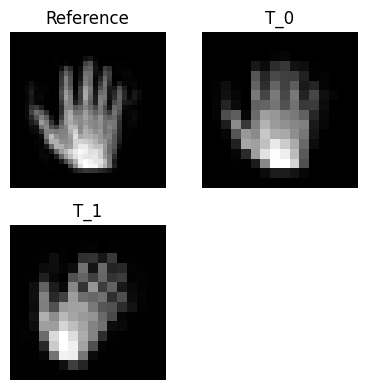

In [3]:
m = 32
factor = 2
theta = 0
n_images = 2

domain_R = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m, m)))
domain_R.m.detach()
domain_T = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m//factor, m//factor)))
xc = domain_R.getCellCenteredGrid().view(-1, 2).to(torch.float64)
times = torch.linspace(0, 15, n_images)

R = Image.open('../data/hands-R.jpg')
R = R.resize((m, m))
R = torch.fliplr(torch.tensor(R.getdata(), dtype=torch.float64).view(m,m).transpose(0,1))
Rimg = SplineInter(R, domain_R ,regularizer='moments',theta=theta).to(torch.float64)

def randomAffines(reference, n):
    affines = [getRandomAffine(rotation_range=(0,45),seed=_+2) for _ in range(n-1)]
    templates = [down_sample(reference(xc).reshape(m, m), factor)]
    for aff in affines:
        affine = Affine2d()
        affine.A = torch.nn.Parameter(aff[0].to(torch.float64))
        affine.b = torch.nn.Parameter(aff[1].to(torch.float64))
        templates.append(down_sample(reference(affine(xc)).reshape(m, m), factor))
    return torch.stack(templates)

T = randomAffines(Rimg, len(times))

show_reference_and_templates(R, T)

In [4]:
def L_forward(f):
    reference = f.reshape(*domain_R.m)
    diff_0 = torch.diff(reference, dim = 0) / domain_R.h[0]
    diff_1 = torch.diff(reference, dim = 1) / domain_R.h[1]
    return torch.hstack([diff_0.flatten(), diff_1.flatten()])

L = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun=L_forward, dtype = torch.float64)

def K_forward(f):
    reference = f.reshape(*domain_R.m)
    downsampled = down_sample(reference, factor).flatten()
    return downsampled.flatten() 

K = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun=K_forward, dtype = torch.float64)
# f0_interp = K.T @ T[0].flatten().detach()
Timg = SplineInter(T[0].detach(),domain_T, regularizer='moments', theta=1e-2)
f0_interp = Timg(domain_R.getCellCenteredGrid()).flatten()

d = T.flatten()
b = torch.hstack([d * torch.sqrt(torch.prod(domain_T.h)), torch.zeros_like(L @ f0_interp)])

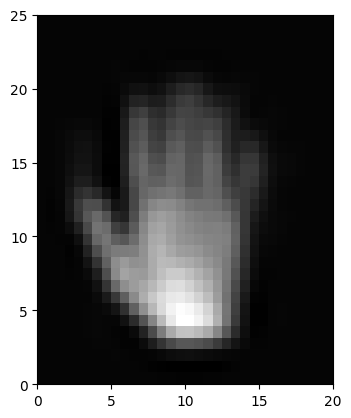

In [5]:
view_image_2d(f0_interp, domain_R)

In [6]:
xc_2d = domain_R.getCellCenteredGrid()
xc = xc_2d.reshape(torch.prod(domain_R.m).item(),2).detach()

ys = [Affine2d() for _ in range(n_images)]
for y in ys:
    for param in y.parameters():
        param.to(torch.float64)
        param.requires_grad_(True)

lam = 1e-2

wps = [{k: v for k, v in y.named_parameters()} for y in ys]
keys_list = [wp.keys() for wp in wps]

flat_params_list, shapes_list, sizes_list = flatten_params_list(wps)
wp_vec0 = torch.stack(flat_params_list).flatten().unsqueeze(1)


In [7]:
f0_grad = None
f0_nograd = None
def conjugate_gradient(A, b, x0, max_iter=500, tol=1e-10):
    x = x0.clone()
    r = b - A(x)
    p = r.clone()
    rsold = r.dot(r)
        
    for i in range(max_iter):
        Ap = A(p)
        alpha = rsold / p.dot(Ap)
        x = x + alpha * p  
        r = r - alpha * Ap  
        rsnew = r.dot(r)
        if torch.sqrt(rsnew) < tol:
            # print(f"tol reached {i}")
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    print(f"residual norm: {torch.sqrt(rsnew)}")
    return x
    

def conjugate_gradient_nograd(A, b, x0, max_iter=500, tol=1e-10):
    with torch.no_grad():
        return conjugate_gradient(A, b, x0, max_iter, tol)
        

def Forward_single(wp, y, f_inter):
    w_dict = unflatten_params(wp, keys_list[0], shapes_list[0], sizes_list[0])
    yc = func.functional_call(y, w_dict, xc)
    d_pred = K(f_inter(yc))
    return d_pred

def res_fn(wp_vec, cg_iter):
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R).to(torch.float64)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])
        lam = 0.0
        regularizer = lam * L(f)
        
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)

    # f0 = conjugate_gradient(A.T ^ A, A.T @ b, f0_interp, max_iter=cg_iter)
    f0 = A_forward(f0_interp)
    # reference = f0.reshape(*domain_R.m)        
    # reference_img = SplineInter(reference, domain_R).to(torch.float64)
    # template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

    return f0

def Jac_fn(wp_vec, cg_iter):
    return func.jacfwd(res_fn)(wp_vec, cg_iter).detach().squeeze()



In [8]:
print(wp_vec0.shape)
res = res_fn(wp_vec0, 2000)
J = Jac_fn(wp_vec0, 2000)
dw = torch.randn_like(wp_vec0)  
dres = J @ dw

for i in range(40):
    h = 0.5**i
    rest = res_fn(wp_vec0 + h * dw, 2000)
    
    err0 = torch.norm(res - rest)
    err1 = torch.norm(res + h * dres - rest)
    print(f"Error at h={h:.3e}: {err0:.3e} vs {err1:.3e}")
    


torch.Size([12, 1])
Error at h=1.000e+00: 1.983e+03 vs 6.013e+05
Error at h=5.000e-01: 2.280e+03 vs 3.177e+05
Error at h=2.500e-01: 2.059e+03 vs 1.805e+05
Error at h=1.250e-01: 1.264e+03 vs 9.741e+04
Error at h=6.250e-02: 7.181e+02 vs 5.159e+04
Error at h=3.125e-02: 3.731e+02 vs 2.629e+04
Error at h=1.562e-02: 1.858e+02 vs 1.312e+04
Error at h=7.812e-03: 9.266e+01 vs 6.550e+03
Error at h=3.906e-03: 4.632e+01 vs 3.275e+03
Error at h=1.953e-03: 2.317e+01 vs 1.638e+03
Error at h=9.766e-04: 1.159e+01 vs 8.191e+02
Error at h=4.883e-04: 5.796e+00 vs 4.096e+02
Error at h=2.441e-04: 2.898e+00 vs 2.048e+02
Error at h=1.221e-04: 1.449e+00 vs 1.024e+02
Error at h=6.104e-05: 7.247e-01 vs 5.120e+01
Error at h=3.052e-05: 3.624e-01 vs 2.560e+01
Error at h=1.526e-05: 1.812e-01 vs 1.280e+01
Error at h=7.629e-06: 9.059e-02 vs 6.400e+00
Error at h=3.815e-06: 4.529e-02 vs 3.200e+00
Error at h=1.907e-06: 2.265e-02 vs 1.600e+00
Error at h=9.537e-07: 1.132e-02 vs 8.001e-01
Error at h=4.768e-07: 5.662e-03 vs 

In [9]:
# the shape of the perturbed vector is wrong because wp_vec0 is not flattened
# When fixed, we see faster rate of convergence using the Jacobian

wp_vec0 = wp_vec0.flatten()
print(wp_vec0.shape)
res = res_fn(wp_vec0, 2000)
J = Jac_fn(wp_vec0, 2000)
dw = torch.randn_like(wp_vec0)  
dres = J @ dw

for i in range(40):
    h = 0.5**i
    rest = res_fn(wp_vec0 + h * dw, 2000)
    
    err0 = torch.norm(res - rest)
    err1 = torch.norm(res + h * dres - rest)
    print(f"Error at h={h:.3e}: {err0:.3e} vs {err1:.3e}")
    


torch.Size([12])
Error at h=1.000e+00: 2.163e+03 vs 1.024e+04
Error at h=5.000e-01: 2.333e+03 vs 5.142e+03
Error at h=2.500e-01: 2.025e+03 vs 2.428e+03
Error at h=1.250e-01: 1.123e+03 vs 9.682e+02
Error at h=6.250e-02: 6.232e+02 vs 3.570e+02
Error at h=3.125e-02: 3.208e+02 vs 1.246e+02
Error at h=1.562e-02: 1.575e+02 vs 3.699e+01
Error at h=7.812e-03: 7.785e+01 vs 1.006e+01
Error at h=3.906e-03: 3.875e+01 vs 2.622e+00
Error at h=1.953e-03: 1.935e+01 vs 6.690e-01
Error at h=9.766e-04: 9.670e+00 vs 1.690e-01
Error at h=4.883e-04: 4.834e+00 vs 4.246e-02
Error at h=2.441e-04: 2.417e+00 vs 1.064e-02
Error at h=1.221e-04: 1.208e+00 vs 2.664e-03
Error at h=6.104e-05: 6.042e-01 vs 6.664e-04
Error at h=3.052e-05: 3.021e-01 vs 1.667e-04
Error at h=1.526e-05: 1.510e-01 vs 4.167e-05
Error at h=7.629e-06: 7.552e-02 vs 1.042e-05
Error at h=3.815e-06: 3.776e-02 vs 2.605e-06
Error at h=1.907e-06: 1.888e-02 vs 6.512e-07
Error at h=9.537e-07: 9.440e-03 vs 1.628e-07
Error at h=4.768e-07: 4.720e-03 vs 4.0